In [6]:
import numpy as np

In [9]:
overt = np.load('/home/owaismujtaba/projects/mind-voice/results/motor/overt.npy')
covert = np.load('/home/owaismujtaba/projects/mind-voice/results/motor/covert.npy')

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem # Standard Error of the Mean
import mne # You might need this to get `times` easily

tmin = -0.1
tmax = 0.6
sfreq = 1000 # Assuming your EEG data was sampled at 1000 Hz, adjust if different

n_times = int(round((tmax - tmin) * sfreq)) + 1
times = np.linspace(tmin, tmax, n_times)

# Load the z-scored power data
overt_z = np.load('results/motor/overt.npy')
covert_z = np.load('results/motor/covert.npy')
rest_z = np.load('results/motor/rest.npy')

# Original channel names from your script
ch_names = ['T7', 'T8', 'FT7', 'FT8']

print(f"Overt data shape: {overt_z.shape}")   # Should be (n_epochs, n_channels, n_times)
print(f"Covert data shape: {covert_z.shape}") # Should be (n_epochs, n_channels, n_times)
print(f"Rest data shape: {rest_z.shape}")     # Should be (n_epochs, n_channels, n_times)
print(f"Times array shape: {times.shape}")

Overt data shape: (5490, 4, 701)
Covert data shape: (5484, 4, 701)
Rest data shape: (10973, 4, 701)
Times array shape: (701,)


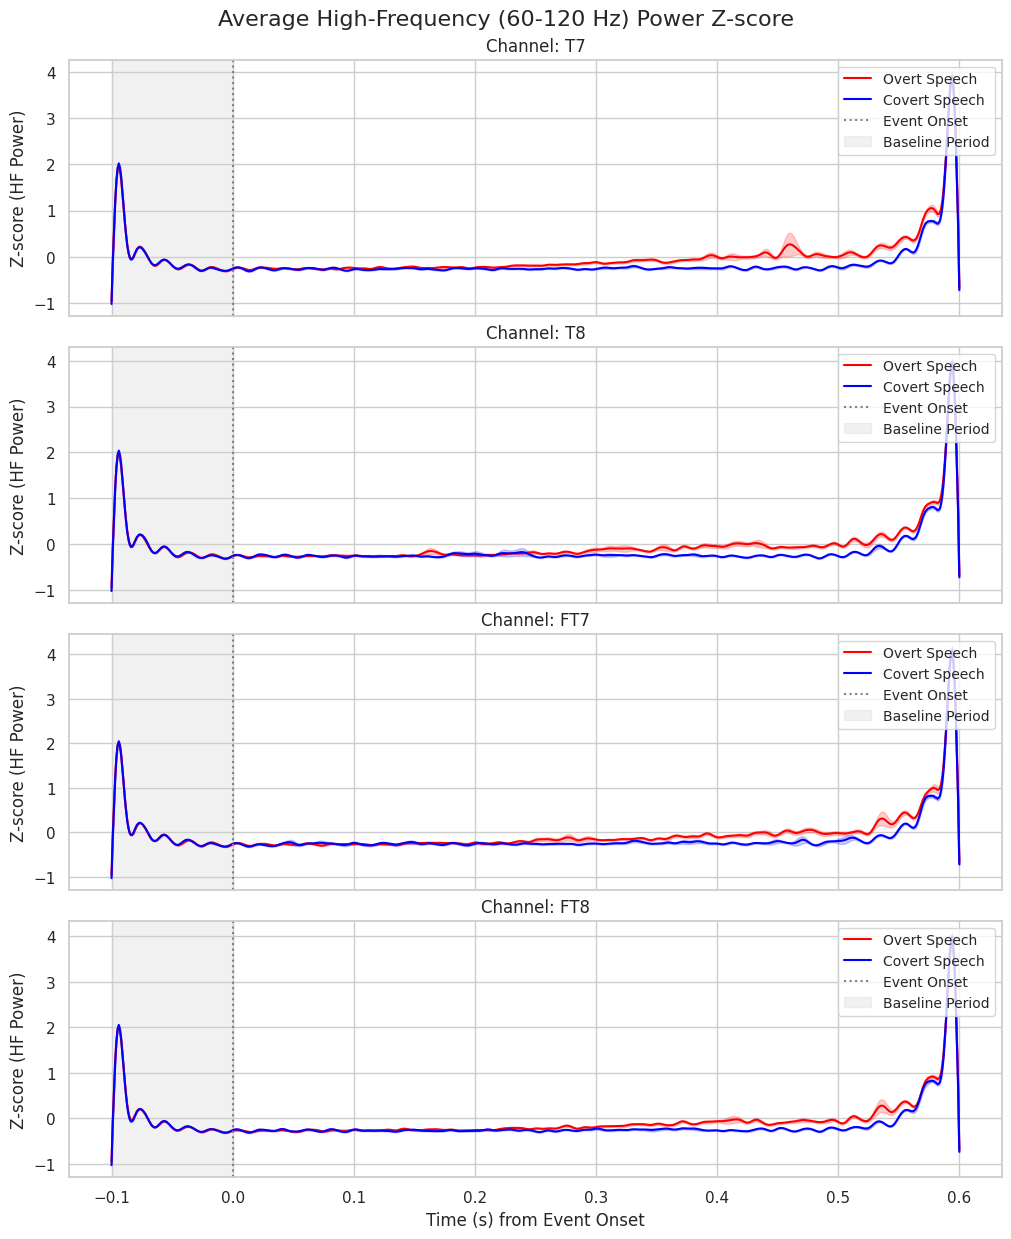

In [22]:
sns.set_theme(style="whitegrid") # Set a nice theme for plots

# Calculate mean and SEM for each condition, for each channel over time
overt_mean = overt_z.mean(axis=0) # Average across epochs
overt_sem = sem(overt_z, axis=0)  # SEM across epochs

covert_mean = covert_z.mean(axis=0)
covert_sem = sem(covert_z, axis=0)

rest_mean = rest_z.mean(axis=0)
rest_sem = sem(rest_z, axis=0)

# Create a figure with subplots, one for each channel
n_channels = len(ch_names)
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 3 * n_channels), sharex=True, layout='constrained')

# Ensure axes is an array even for a single channel
if n_channels == 1:
    axes = [axes]

for i, ch_name in enumerate(ch_names):
    ax = axes[i]

    # Plot Overt Speech
    ax.plot(times, overt_mean[i, :], label='Overt Speech', color='red')
    ax.fill_between(times, overt_mean[i, :] - overt_sem[i, :],
                    overt_mean[i, :] + overt_sem[i, :], color='red', alpha=0.2)

    # Plot Covert Speech
    ax.plot(times, covert_mean[i, :], label='Covert Speech', color='blue')
    ax.fill_between(times, covert_mean[i, :] - covert_sem[i, :],
                    covert_mean[i, :] + covert_sem[i, :], color='blue', alpha=0.2)

    # Plot Rest
   
    ax.axvline(0, color='gray', linestyle=':', label='Event Onset')

    # Add a shaded region for the baseline period
    ax.axvspan(-0.1, 0, color='lightgray', alpha=0.3, label='Baseline Period')

    # Set titles and labels
    ax.set_title(f'Channel: {ch_name}')
    ax.set_ylabel('Z-score (HF Power)')
    ax.legend(loc='upper right', fontsize='small')

# Set common x-axis label for the bottom subplot
axes[-1].set_xlabel('Time (s) from Event Onset')

# Add a super title for the entire figure
fig.suptitle('Average High-Frequency (60-120 Hz) Power Z-score', fontsize=16, y=1.02)
plt.show()

In [1]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    return b, a


def bandpass_filter(data, fs, lowcut=60.0, highcut=120.0, order=4):
    """
    data: ndarray (..., n_times)
    returns filtered data with same shape, using filtfilt along last axis
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = signal.filtfilt(b, a, data, axis=-1, padlen=3*(max(len(a), len(b))))
    return filtered


def compute_trial_power(trials, temporalChannels, fs, lowcut=60.0, highcut=120.0, order=4):
    """
    trials: ndarray (n_trials, n_channels, n_times)
    temporalChannels: list or array of channel indices to include
    returns: 1D array length n_trials with mean-squared amplitude (power) computed
             after bandpass filtering between lowcut-highcut, averaged across time
             and the selected channels for each trial.
    """
    # Validate
    if trials.ndim != 3:
        raise ValueError("trials must have shape (n_trials, n_channels, n_times)")
    nTrials, nChannels, nTimes = trials.shape
    # Select channels
    sel = np.asarray(temporalChannels, dtype=int)
    if sel.max() >= nChannels or sel.min() < 0:
        raise IndexError("temporalChannels contains invalid channel indices for input trials")
    # Filter: apply filter per trial and per selected channel
    # For efficiency, filter all selected channels across all trials in one array
    selectedData = trials[:, sel, :]  # shape (n_trials, n_sel_channels, n_times)
    # reshape to (n_trials*n_sel_channels, n_times) for vectorized filtering
    reshaped = selectedData.reshape(-1, nTimes)
    filtered = bandpass_filter(reshaped, fs, lowcut=lowcut, highcut=highcut, order=order)
    filtered = filtered.reshape(nTrials, len(sel), nTimes)
    # Compute mean squared amplitude across time and channels for each trial
    powerPerTrial = np.mean(filtered**2, axis=(1, 2))  # shape (n_trials,)
    return powerPerTrial


def analyzeSession(epochs_by_condition, sfreq, temporalChannels,
                   filterFreqs=(60.0, 120.0), filterOrder=4, doPlot=False):
    """
    epochs_by_condition: dict with keys 'overt','covert','rest' -> ndarray (n_trials, n_channels, n_times)
    sfreq: sampling frequency in Hz
    temporalChannels: list of channel indices used for averaging
    filterFreqs: (low, high) bandpass limits
    filterOrder: Butterworth order
    doPlot: if True, show histograms of per-trial power by condition

    Returns:
      results dict with:
        - perTrialPower: dict condition -> 1D array (n_trials,)
        - meanPower: dict condition -> scalar
        - stdPower: dict condition -> scalar
        - ttests: dict pair_name -> (t_stat, p_value, n_pair)
    """
    required = {"overt", "covert", "rest"}
    if not required.issubset(set(epochs_by_condition.keys())):
        raise KeyError(f"epochs_by_condition must include keys: {required}")

    lowcut, highcut = filterFreqs
    perTrialPower = {}
    for cond in ["overt", "covert", "rest"]:
        trials = np.asarray(epochs_by_condition[cond])
        perTrialPower[cond] = compute_trial_power(
            trials, temporalChannels, sfreq, lowcut=lowcut, highcut=highcut, order=filterOrder
        )

    meanPower = {c: float(np.mean(perTrialPower[c])) for c in perTrialPower}
    stdPower = {c: float(np.std(perTrialPower[c], ddof=1)) for c in perTrialPower}

    # Paired-sample comparisons: use ttest_rel. Require equal lengths for paired test.
    def paired_ttest(a, b):
        a = np.asarray(a)
        b = np.asarray(b)
        if a.size != b.size:
            # If lengths differ, truncate to common min length and warn (paired tests require pairing).
            n = min(a.size, b.size)
            a = a[:n]; b = b[:n]
        t, p = stats.ttest_rel(a, b)
        return float(t), float(p), a.size

    ttests = {}
    pairs = [("overt", "covert"), ("overt", "rest"), ("covert", "rest")]
    for a, b in pairs:
        ttests[f"{a}_vs_{b}"] = paired_ttest(perTrialPower[a], perTrialPower[b])

    results = {
        "perTrialPower": perTrialPower,
        "meanPower": meanPower,
        "stdPower": stdPower,
        "ttests": ttests,
        "filterFreqs": (lowcut, highcut),
        "sfreq": sfreq,
        "temporalChannels": np.asarray(temporalChannels).tolist(),
    }

    if doPlot:
        plt.figure(figsize=(8, 4))
        bins = 15
        for cond in ["overt", "covert", "rest"]:
            plt.hist(perTrialPower[cond], bins=bins, alpha=0.5, label=f"{cond} (n={len(perTrialPower[cond])})")
        plt.xlabel("Mean high-frequency power (60-120 Hz)")
        plt.ylabel("Count")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results

In [ ]:

audio = {
        "label": "Auditory",
        "trial_type": "",
        "tmin": -0.1,
        "tmax": 0.5,
        "trial_mode": "Words",
        "trial_unit": "Speech",
        "experiment_mode": "Experiment",
        "trial_boundary": "Start",
        "modality": "Audio",
        "time_window": (0.08, 0.12),
        "baseline": {"tmin": -0.1, "tmax": 0}
    }
    

no_audio = {
        "label": "Non Auditory",
        "trial_type": "",
        "tmin": 0.3,
        "tmax": 0.9,
        "trial_mode": "Words",
        "trial_unit": "Fixation",
        "experiment_mode": "Experiment",
        "trial_boundary": "Start",
        "modality": "Audio",
        "time_window": (0.38, 0.42),
        "baseline": {"tmin": 0.3, "tmax": 0.4}
    }

In [3]:
from src.pipelines.n100_pipeline import N100Pipeline
sub = '01'
ses = '01'
pipe = N100Pipeline(
                    subject_id=sub, session_id=ses,
                    config=config, logger=logger,
                    cond_1=audio, cond_2=no_audio,
                    channels=['Fz', 'Cz']
                )
                
pipe.run(plot=False)

[2025-12-10 11:34:33] [INFO] ************************************************************
[2025-12-10 11:34:33] [INFO] **********Initializing BIDSDatasetReader**********
[2025-12-10 11:34:33] [INFO] ************************************************************
[2025-12-10 11:34:33] [INFO] Processed EEG file exists. Loading...
[2025-12-10 11:34:33] [INFO] Loading processed EEG from BIDS/derivatives/low-0.1_high-40.0_ICA-True/sub-01_ses-01_processed.fif


Opening raw data file BIDS/derivatives/low-0.1_high-40.0_ICA-True/sub-01_ses-01_processed.fif...
    Range : 0 ... 6306999 =      0.000 ...  6306.999 secs
Ready.


/home/owaismujtaba/projects/mind-voice/src/dataset/data_reader.py:90: RuntimeWarning: This filename (BIDS/derivatives/low-0.1_high-40.0_ICA-True/sub-01_ses-01_processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  self.processed_eeg = mne.io.read_raw_fif(filepath, preload=True)


Reading 0 ... 6306999  =      0.000 ...  6306.999 secs...


[2025-12-10 11:34:34] [INFO] Creating epochs for condition: Auditory
[2025-12-10 11:34:34] [INFO] ************************************************************
[2025-12-10 11:34:34] [INFO] **********Initializing Epoch Builder**********
[2025-12-10 11:34:34] [INFO] ************************************************************
[2025-12-10 11:34:34] [INFO] Creating Epochs


        Extraction Criteria        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Parameter          ┃ Value      ┃
┣━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ 🧪 Trial Mode      ┃ Words      ┃
┃ 📏 Trial Unit      ┃ Speech     ┃
┃ 🔗 Experiment Mode ┃ Experiment ┃
┃ 🎭 Trial Boundary  ┃ Start      ┃
┃ 🔬 Trial Type      ┃            ┃
┃ 📊 Modality        ┃ Audio      ┃
┃ ⏱ Tmin             ┃ -0.1       ┃
┃ ⏳ Tmax            ┃ 0.5        ┃
┗━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━┛

[2025-12-10 11:34:34] [INFO] Baseline {'tmin': -0.1, 'tmax': 0}


Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 190 events and 601 original time points ...
0 bad epochs dropped


[2025-12-10 11:34:34] [INFO] Creating epochs for condition: Non Auditory
[2025-12-10 11:34:34] [INFO] ************************************************************
[2025-12-10 11:34:34] [INFO] **********Initializing Epoch Builder**********
[2025-12-10 11:34:34] [INFO] ************************************************************
[2025-12-10 11:34:34] [INFO] Creating Epochs


        Extraction Criteria        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Parameter          ┃ Value      ┃
┣━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━┫
┃ 🧪 Trial Mode      ┃ Words      ┃
┃ 📏 Trial Unit      ┃ Fixation   ┃
┃ 🔗 Experiment Mode ┃ Experiment ┃
┃ 🎭 Trial Boundary  ┃ Start      ┃
┃ 🔬 Trial Type      ┃            ┃
┃ 📊 Modality        ┃ Audio      ┃
┃ ⏱ Tmin             ┃ 0.3        ┃
┃ ⏳ Tmax            ┃ 0.9        ┃
┗━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━┛

[2025-12-10 11:34:34] [INFO] Baseline {'tmin': 0.3, 'tmax': 0.4}


Not setting metadata
190 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 190 events and 601 original time points ...
0 bad epochs dropped


[2025-12-10 11:34:34] [INFO] Saving results
[2025-12-10 11:34:34] [INFO] Saving to /home/owaismujtaba/projects/mind-voice/results/N100


In [5]:
overt = pipe.cond1_epochs
covert = pipe.cond2_epochs

In [6]:
overt.get_data().shape

(190, 2, 601)

In [ ]:
import numpy as np
from scipy import signal, stats


def bandpass_filter(data, fs, low=60.0, high=120.0, order=4):
    nyq = 0.5 * fs
    b, a = signal.butter(order, [low/nyq, high/nyq], btype="band")
    return signal.filtfilt(b, a, data, axis=-1)


def compute_power(epochs, temporalChannels, sfreq):
    """
    epochs: (n_trials, n_channels, n_times)
    temporalChannels: list of channel indices to average over
    returns: power per trial, shape (n_trials,)
    """
    data = epochs[:, temporalChannels, :]                # (trials, sel_ch, time)
    n_trials, n_ch, n_times = data.shape

    # reshape to vectorized filtering
    reshaped = data.reshape(n_trials * n_ch, n_times)
    filtered = bandpass_filter(reshaped, sfreq, 60, 120, 4)
    filtered = filtered.reshape(n_trials, n_ch, n_times)

    # mean squared amplitude
    power = np.mean(filtered**2, axis=(1, 2))
    return power


def analyze_overt_covert(overtEpochs, covertEpochs, temporalChannels, sfreq):
    overtPower = compute_power(overtEpochs, temporalChannels, sfreq)
    covertPower = compute_power(covertEpochs, temporalChannels, sfreq)

    # paired t-test
    n = min(len(overtPower), len(covertPower))
    t, p = stats.ttest_rel(overtPower[:n], covertPower[:n])

    return {
        "overtPower": overtPower,
        "covertPower": covertPower,
        "meanOvert": float(np.mean(overtPower)),
        "meanCovert": float(np.mean(covertPower)),
        "t": float(t),
        "p": float(p),
        "n": int(n)
    }


In [ ]:
res = analyze_overt_covert(
    overtEpochs=overt.get_data(),      # shape (n_epochs, n_channels, n_times)
    covertEpochs=covert.get_data(),
    temporalChannels=[20,21,22,23,24],        # your temporal channels
    sfreq=overt.info["sfreq"]
)

print(res)